# hw3: Обучение без учителя

*Спасибо ещё одному великому курсу mlcourse.ai и авторам: Ольга Дайховская (@aiho в Slack ODS), Юрий Кашницкий (@yorko в Slack ODS).*

### О задании

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в
задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице.

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации.

**Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы, выделив ответ полужирным** (``` **выделить двойными звёздочками** ```).

### Оценивание и штрафы
Вам необходимо ответить на 10 вопросов и выполнить 2 задания. Каждое из заданий и вопросов имеет определенную «стоимость» (указана в скобках). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw3-unsupervised.ipynb``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце "hw3" в строке со своей фамилией о том, что вы выполнили работу и оставить ссылку на ноутбук.


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt

plt.style.use(['seaborn-v0_8-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [5]:
X_train = np.loadtxt("/kaggle/input/uci-har/X_train.txt")
y_train = np.loadtxt("/kaggle/input/uci-har/y_train.txt").astype(int)

X_test = np.loadtxt("/kaggle/input/uci-har/X_test.txt")
y_test = np.loadtxt("/kaggle/input/uci-har/y_test.txt").astype(int)

In [6]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*.

In [7]:
X = np.vstack((X_train, X_test))
y = np.concatenate((y_train, y_test))

Определим число уникальных значений меток целевого класса.

In [8]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [9]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

*уж простите, если звучание этих существительных кажется корявым :)*

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [11]:
pca = PCA(0.9, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

In [12]:
X_pca

array([[-16.38097982,   1.99508307,   3.41569023, ...,   0.34256962,
         -0.24397444,  -1.94678658],
       [-15.58217328,   1.18259368,  -0.32120675, ...,   0.13742091,
         -0.16081322,  -0.61432028],
       [-15.42398918,   2.24316643,  -1.23778356, ...,  -1.47098019,
         -1.24311139,   0.24672176],
       ...,
       [ 11.84685312,  -3.43356502,   2.18801926, ...,  -0.94467044,
         -0.34497972,  -2.09465647],
       [  8.20668637,  -4.38648876,   1.31871955, ...,   0.11723446,
         -1.32786056,   0.08742446],
       [  9.31117251,  -3.98616133,   1.93301747, ...,   0.12988206,
         -1.86396408,  -0.18253505]])

**Вопрос 1:** (1 балл)

Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

**Варианты:**
- 56
- **65**
- 66
- 193

In [13]:
pca.n_components_

65

**Вопрос 2:** (0.5 баллов)

Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов.

**Варианты:**
- 45
- **51**
- 56
- 61

In [14]:
pca.explained_variance_ratio_

array([0.50738221, 0.06239186, 0.02692564, 0.02452871, 0.01888936,
       0.01631395, 0.01414533, 0.01216211, 0.00985248, 0.00949228,
       0.00858304, 0.0080998 , 0.00765863, 0.00676668, 0.00630242,
       0.00615718, 0.00595335, 0.00577195, 0.00563431, 0.0054083 ,
       0.00518828, 0.00502742, 0.00473229, 0.00463818, 0.00446848,
       0.00439868, 0.00416863, 0.00400809, 0.00389072, 0.00381339,
       0.0036687 , 0.00364357, 0.00349225, 0.00346736, 0.00335539,
       0.00329411, 0.00323824, 0.00300508, 0.00294254, 0.00290452,
       0.00275765, 0.00269864, 0.00264196, 0.0025803 , 0.00255031,
       0.00247776, 0.00245537, 0.0023829 , 0.00235902, 0.00232044,
       0.0022836 , 0.00219182, 0.00212631, 0.00209145, 0.0020348 ,
       0.00201167, 0.00198111, 0.00194391, 0.00192509, 0.00189539,
       0.00186403, 0.00182923, 0.00180956, 0.00176364, 0.00174188])

Визуализируйте данные в проекции на первые две главные компоненты.

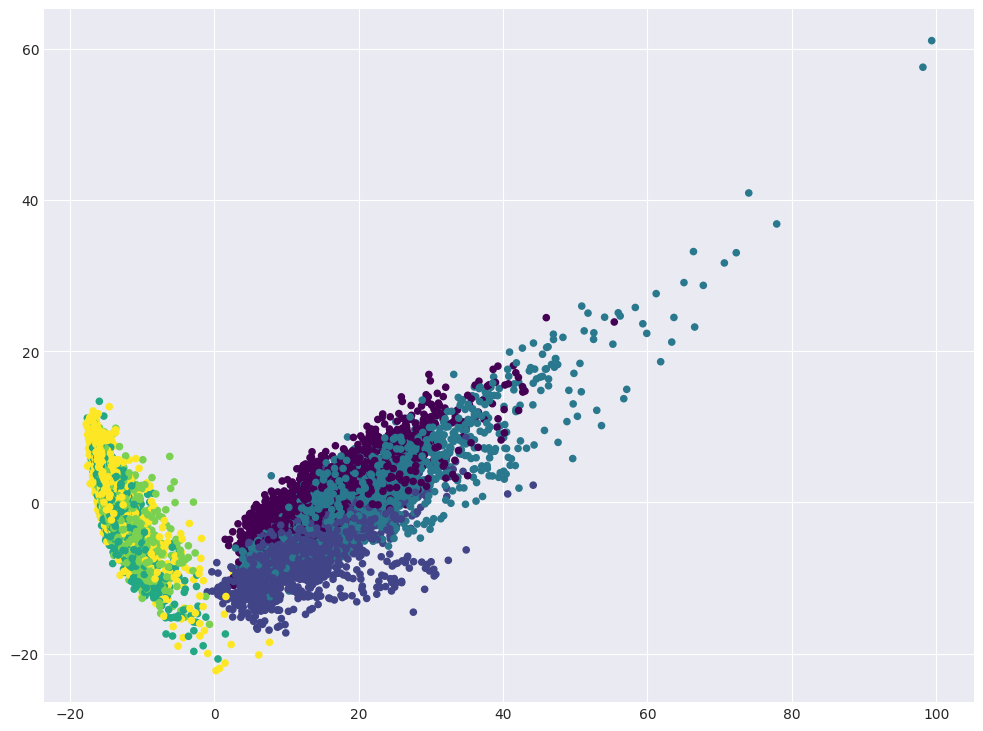

In [15]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap='viridis')

**Вопрос 3:** (0.5 баллов)

Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- **2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)**
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 6 кластеров

------------------------------

**Задание 1.** (1 балл)

Сделайте кластеризацию данных методом `KMeans` (собственная имплементация и готовая реализация), обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [16]:
class KMeansImpl:
    def __init__(self, n_clusters, n_init=10, max_iter=300, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        
        self.cluster_centers_ = None
        self.labels_ = None
        self.inertia_ = np.inf

    def fit(self, X):
        np.random.seed(self.random_state)
        best_inertia = np.inf
        best_centers = None
        best_labels = None

        for i in range(self.n_init):
            indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
            centroids = X[indices]
            
            for iter_no in range(self.max_iter):
                distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
                labels = np.argmin(distances, axis=1)

                new_centroids = np.array([X[labels == k].mean(axis=0) 
                                          if np.sum(labels == k) > 0 else centroids[k]
                                          for k in range(self.n_clusters)])

                shift = np.linalg.norm(new_centroids - centroids)
                centroids = new_centroids
                
                if shift < self.tol:
                    break
            
            final_distances = np.min(np.linalg.norm(X[:, np.newaxis] - centroids, axis=2), axis=1)
            current_inertia = np.sum(final_distances ** 2)

            if current_inertia < best_inertia:
                best_inertia = current_inertia
                best_centers = centroids
                best_labels = labels
        
        self.cluster_centers_ = best_centers
        self.labels_ = best_labels
        self.inertia_ = best_inertia
        return self

    def predict(self, X):
        distances = np.linalg.norm(X[:, np.newaxis] - self.cluster_centers_, axis=2)
        return np.argmin(distances, axis=1)

In [17]:
n_clusters = n_classes
n_init = 100

my_kmeans = KMeansImpl(n_clusters=n_clusters, n_init=n_init, random_state=RANDOM_STATE)
my_kmeans.fit(X_pca)

sklearn_kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, random_state=RANDOM_STATE)
sklearn_kmeans.fit(X_pca)

print(f"MyKMeans Inertia:      {my_kmeans.inertia_:.4f}")
print(f"Sklearn KMeans Inertia: {sklearn_kmeans.inertia_:.4f}")

MyKMeans Inertia:      2003454.2019
Sklearn KMeans Inertia: 2003454.8999


Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

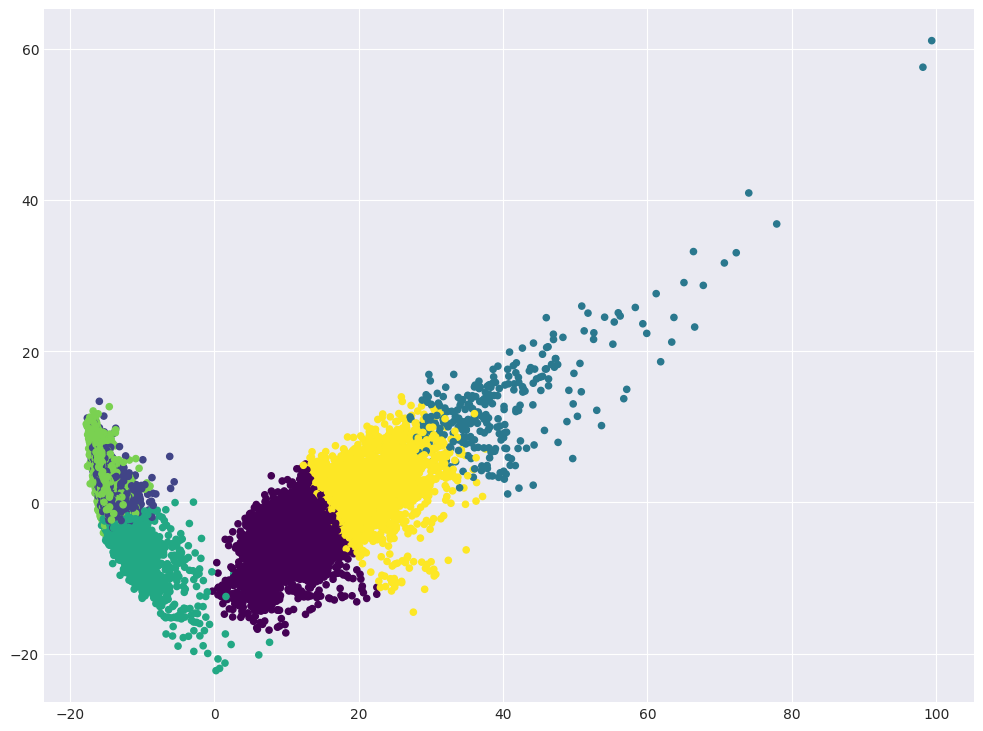

In [18]:
cluster_labels = my_kmeans.labels_
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=20,  cmap='viridis');

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [19]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице',
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,901,0,78,0,0,743,1722
подъем вверх по лестнице,1239,0,5,2,0,298,1544
спуск по лестнице,319,0,196,0,0,891,1406
сидение,1,1235,0,450,91,0,1777
стояние,0,1344,0,562,0,0,1906
лежание,5,52,0,329,1558,0,1944
все,2465,2631,279,1343,1649,1932,10299


Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации.

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,

то такая доля будет 900 / 1406 $\approx$ 0.64.


**Вопрос 4:** (1 балл)

Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- **перечисленные варианты не подходят**

In [20]:
1558/1944, 1239/1544, # лежание, подъем вверх

(0.801440329218107, 0.802461139896373)

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

In [21]:
inertia = []
for k in tqdm_notebook(range(1, n_classes + 1)):
    kmeans = KMeansImpl(n_clusters=k, n_init=100, random_state=RANDOM_STATE)
    
    kmeans.fit(X_pca)
    
    inertia.append(kmeans.inertia_)

inertia

/tmp/ipykernel_47/2008461602.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(1, n_classes + 1)):


  0%|          | 0/6 [00:00<?, ?it/s]

[5202757.68164393,
 2697926.758229884,
 2346425.1043448625,
 2207131.4739273796,
 2080984.9145103693,
 2003454.201875125]

Text(0, 0.5, 'Инерция')

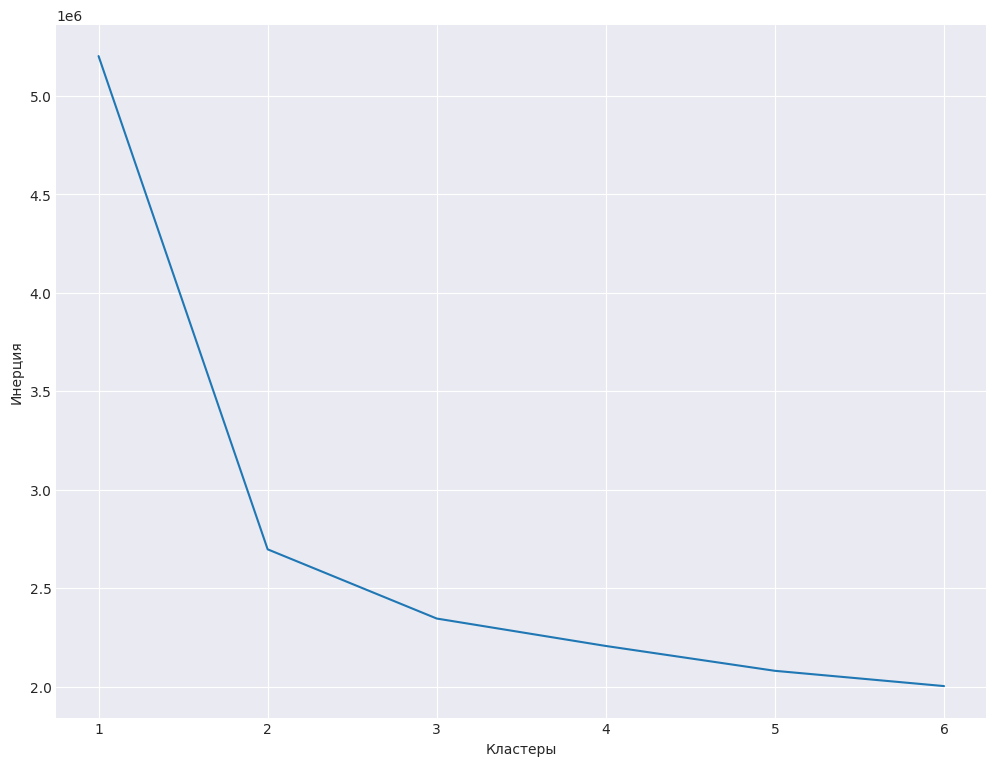

In [28]:
plt.plot(range(1, 7), inertia)
plt.xlabel('Кластеры')
plt.ylabel('Инерция')

**Вопрос 5:** (1 балл)

Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- **2**
- 3
- 4

------------------------

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [29]:
ag = AgglomerativeClustering(n_clusters=n_classes,
                             linkage='ward').fit(X_pca)

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [91]:
metrics.adjusted_rand_score(y, ag.labels_), metrics.adjusted_rand_score(y, my_kmeans.labels_)

(0.49362763373004886, 0.41970615516429294)

**Вопрос 6:** (1 балл)

Отметьте все верные утверждения.<br>

**Варианты:**
- **Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering**
- **Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры**
- **В случае случайного разбиения на кластеры ARI будет близок к нулю**

-------------------------------

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf).

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`.

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [36]:
new_scaler = StandardScaler()
X_train_scaled = new_scaler.fit_transform(X_train)
X_test_scaled = new_scaler.transform(X_test)

In [55]:
svc = LinearSVC(random_state=RANDOM_STATE, max_iter=50_000)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [50]:
best_svc = GridSearchCV(svc, svc_params, cv=3, verbose=True)

In [51]:
best_svc.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


GridSearchCV(cv=3,
             estimator=LinearSVC(dual=False, max_iter=50000, random_state=17),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]}, verbose=True)

In [54]:
best_svc.best_params_

{'C': 0.1}

**Вопрос 7** (0.5 баллов)

Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- **0.1**
- 1
- 10

In [52]:
y_predicted = best_svc.predict(X_test_scaled)

In [53]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице',
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,494,2,0,0,0,0,496
подъем вверх по лестнице,12,459,0,0,0,0,471
спуск по лестнице,2,4,413,1,0,0,420
сидение,0,4,0,426,61,0,491
стояние,0,0,0,15,517,0,532
лежание,0,0,0,0,11,526,537
все,508,469,413,442,589,526,2947


In [70]:
metrics.precision_score(y_predicted, y_test, average=None), metrics.recall_score(y_predicted, y_test, average=None)

(array([0.99596774, 0.97452229, 0.98333333, 0.86761711, 0.97180451,
        0.97951583]),
 array([0.97244094, 0.97867804, 1.        , 0.9638009 , 0.87775891,
        1.        ]))

**Вопрос 8:** (0.5 балл)

Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- **по точности – сидение, по полноте – стояние**

In [73]:
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [74]:
best_svc_pca = GridSearchCV(svc, svc_params, cv=3)
best_svc_pca.fit(X_train_pca, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

GridSearchCV(cv=3, estimator=LinearSVC(max_iter=50000, random_state=17),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]})

In [76]:
best_svc_pca.best_params_

{'C': 0.1}

In [87]:
(best_svc.best_score_ - best_svc_pca.best_score_) * 100

3.958023519485321


Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

**Вопрос 9:** (1 балл)

Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- 2%
- **4%**
- 10%
- 20%


**Вопрос 10:** (1 балл)

Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- **PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность**
- **PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком**

**Задание 2.** (1 балл)

Попробуйте использовать DBSCAN в качестве алгоритма кластеризации и метод понижения размерности tSNE.

In [88]:
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE

In [92]:
tsne = TSNE(random_state=RANDOM_STATE)

X_tsne = tsne.fit_transform(X_scaled)

In [210]:
dbscan = DBSCAN(eps=4, min_samples=20)

labels = dbscan.fit_predict(X_tsne)

<Axes: >

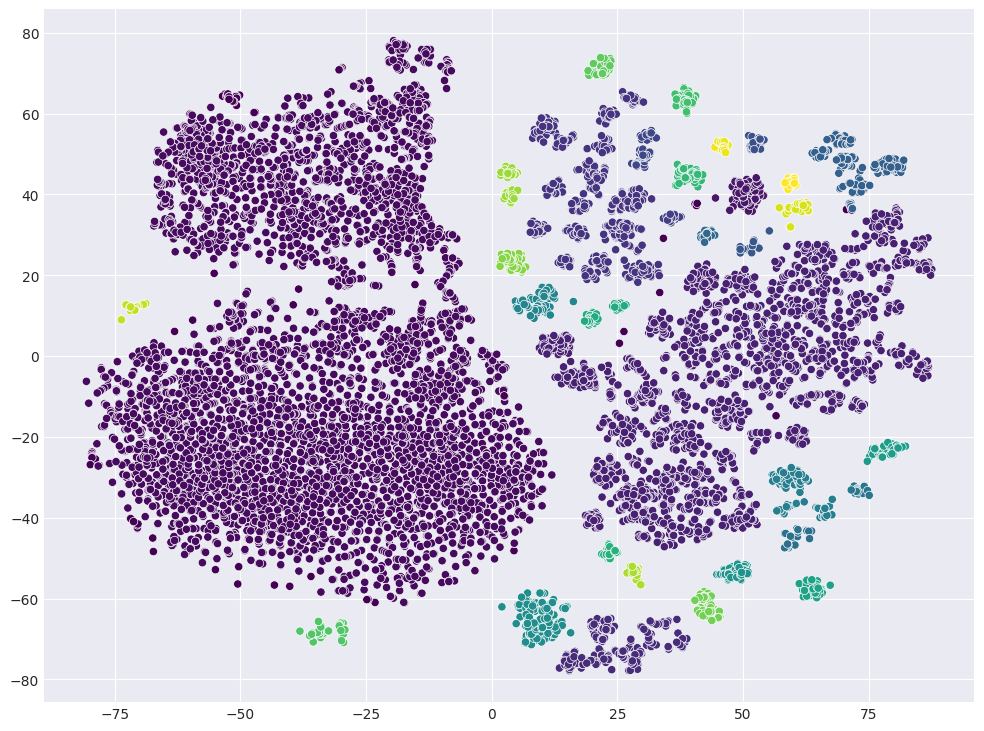

In [212]:
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], c=labels, cmap='viridis')